# Scrape links from https://justjoin.it/

## Imports

In [1]:
import requests
import os
import json

import pandas as pd
import numpy as np

## Request data

In [2]:
data_dump_path = os.path.join(os.getcwd(), "data", "just_join_data.json")

if not os.path.exists(data_dump_path):
    data = requests.get("https://justjoin.it/api/offers").json()

    os.makedirs(os.path.dirname(data_dump_path), exist_ok=True)

    with open(data_dump_path, "w") as jw:
        json.dump(data, jw)
else:
    with open(data_dump_path) as jw:
        data = json.load(jw)


## Process data

### First data clean up

#### Remove unnecessary fileds

In [3]:
DATA_COLS = (
    'title',
    'country_code',
    'experience_level',
    'employment_types',
    'skills',
    'id',
)
first_clean_data = []

In [4]:
for d in data:
    d_clean = dict.fromkeys(DATA_COLS)
    for k in d_clean:
        d_clean[k] = d[k]
    
    first_clean_data.append(d_clean)
len(first_clean_data), first_clean_data[:2]

(15200,
 [{'title': 'Test Automation Developer',
   'country_code': 'PL',
   'experience_level': 'mid',
   'employment_types': [{'type': 'b2b',
     'salary': {'from': 12000, 'to': 16000, 'currency': 'pln'}},
    {'type': 'permanent',
     'salary': {'from': 12000, 'to': 16000, 'currency': 'pln'}}],
   'skills': [{'name': 'REST API', 'level': 3},
    {'name': 'Test plan', 'level': 3},
    {'name': 'Test Automation', 'level': 3}],
   'id': 'cloudferro-sp-z-o-o-test-automation-developer-warszawa'},
  {'title': 'Architekt Systemów Informatycznych',
   'country_code': 'PL',
   'experience_level': 'senior',
   'employment_types': [{'type': 'b2b',
     'salary': {'from': 21000, 'to': 30000, 'currency': 'pln'}},
    {'type': 'permanent',
     'salary': {'from': 21000, 'to': 30000, 'currency': 'pln'}}],
   'skills': [{'name': 'UML', 'level': 4},
    {'name': 'SOA', 'level': 4},
    {'name': 'Software Architecture', 'level': 5}],
   'id': 'cloudferro-sp-z-o-o-architekt-systemow-informatycznych-

#### Extract skills and skills that go in tandem with it

In [5]:
skills = {}
for d in first_clean_data:
    d_skills = d.get("skills")

    for d_skill in d_skills:
        if (d_skill_name := d_skill.get("name")) not in skills:
            skills[d_skill_name] = {"count": 0, "skills_together": {}}

        skills[d_skill_name]["count"] += 1

        for d_skill_temp in d_skills:
            if d_skill_temp.get("name") == d_skill_name:
                continue

            if (d_skill_temp_name := d_skill_temp.get("name")) not in skills[
                d_skill_name
            ]["skills_together"]:
                skills[d_skill_name]["skills_together"][d_skill_temp_name] = 0

            skills[d_skill_name]["skills_together"][d_skill_temp_name] += 1


In [6]:
skills_list = [{'name': key, **value} for key, value in skills.items()]
skills_list.sort(key=lambda x: x['count'], reverse=True)

#### Some simple visualization with received data

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
example_skill = "Java"
example_skill_data = skills.get(example_skill)

In [9]:
example_skill_position = [
    i for i in range(len(skills_list)) if skills_list[i].get("name") == example_skill
][0] + 1
print(
    f"{example_skill} is {example_skill_position} of {len(skills_list)} the emerging techologies that employers are looking for on portal Just Join IT."
)
print(
    f"{example_skill} appears in {example_skill_data.get('count')} of {len(data)} vacancies. Roughly {100 * example_skill_data.get('count') / len(data):.2f}% of proposals"
)


Java is 1 of 1668 the emerging techologies that employers are looking for on portal Just Join IT.
Java appears in 1863 of 15200 vacancies. Roughly 12.26% of proposals


Text(0, 0.5, 'Amount of appearences')

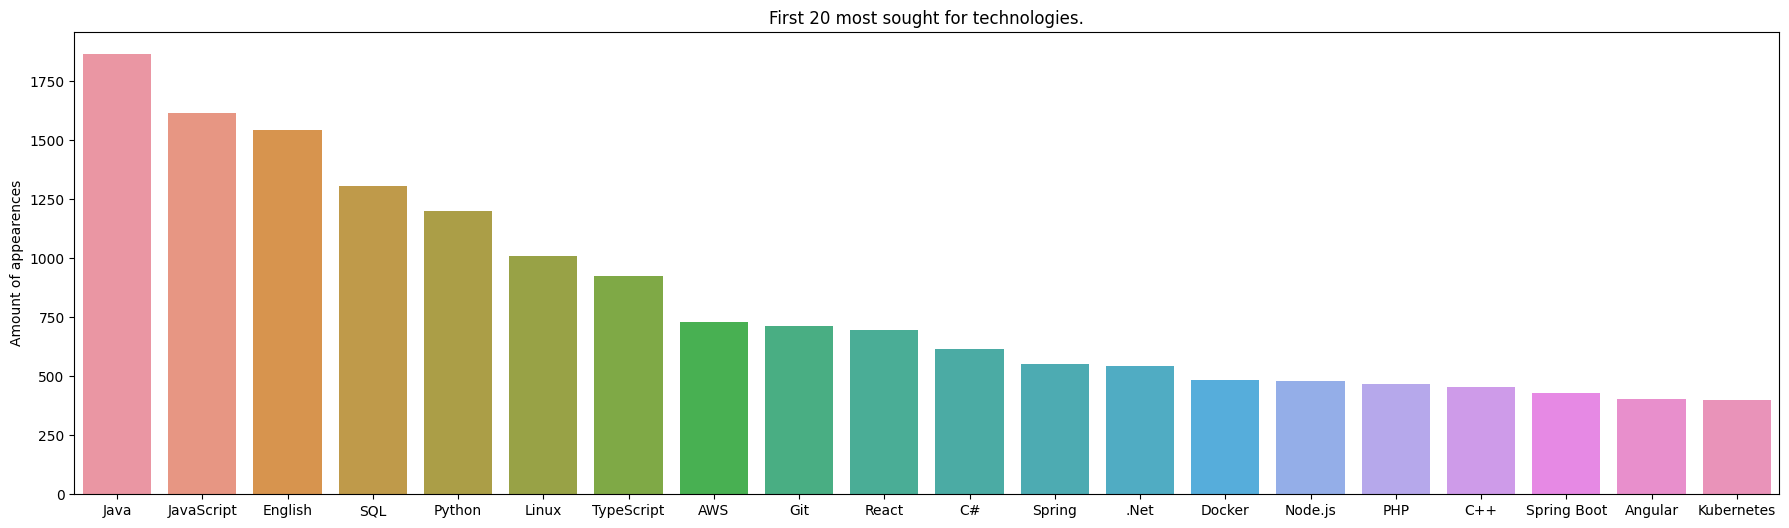

In [10]:
plt.figure(figsize=(22, 6))
plt.title("First 20 most sought for technologies.")

sns.barplot(
    x=[skill_name.get("name") for skill_name in skills_list[:20]],
    y=[skill_name.get("count") for skill_name in skills_list[:20]],
)

plt.ylabel("Amount of appearences")

In [11]:
example_skill_skills_list = [
    (skill, count) for skill, count in example_skill_data.get("skills_together").items()
]
example_skill_skills_list.sort(key=lambda x: x[1], reverse=True)

Text(0, 0.5, 'Amount of appearences.')

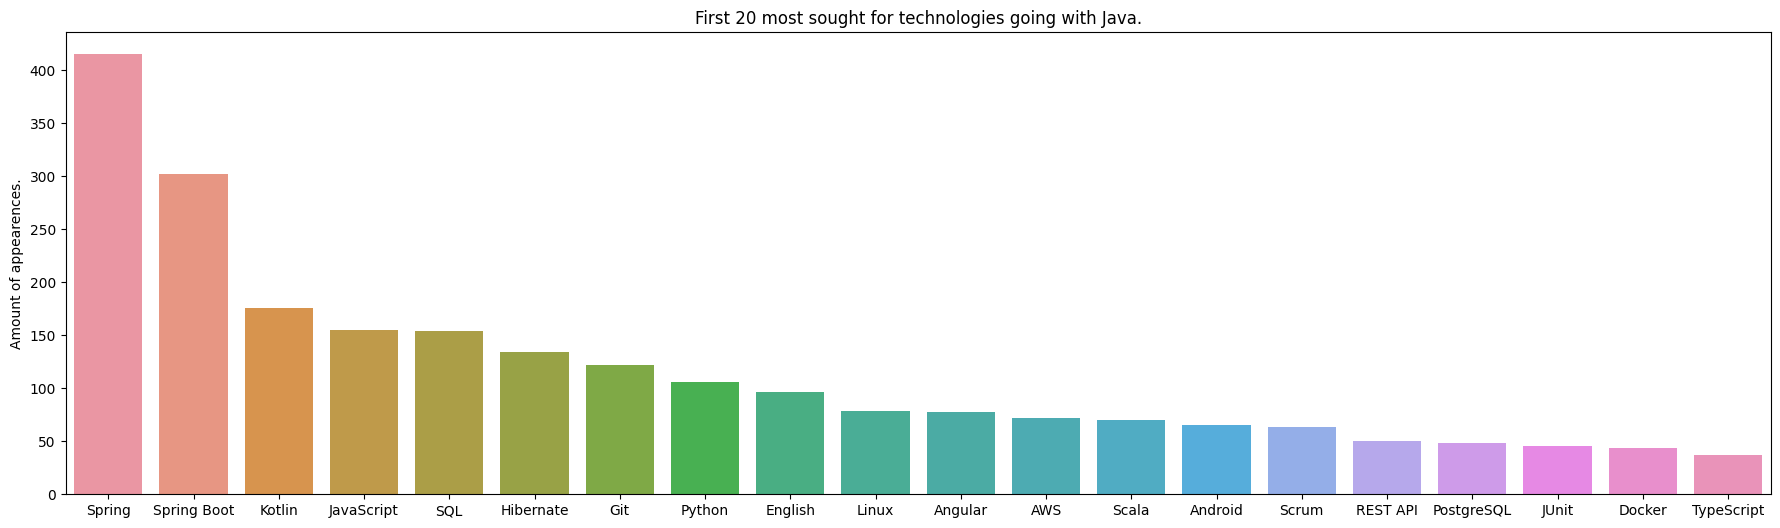

In [12]:
plt.figure(figsize=(22, 6))
plt.title(f"First 20 most sought for technologies going with {example_skill}.")

sns.barplot(
    x=[skill_name[0] for skill_name in example_skill_skills_list][:20],
    y=[skill_name[1] for skill_name in example_skill_skills_list][:20],
)

plt.ylabel("Amount of appearences.")

In [13]:
columns = index = [skill.get('name') for skill in skills_list[:10]]

df_repetitions = pd.DataFrame(columns=columns, index=index[::-1], dtype=float)

for x in columns:
    for y in index:
        if x == y:
            continue

        df_repetitions[x][y] = skills.get(x).get("skills_together").get(y) or 0
df_repetitions

,Java,JavaScript,English,SQL,Python,Linux,TypeScript,AWS,Git,React
React,32.0,349.0,19.0,1.0,18.0,0.0,269.0,11.0,9.0,NaN
Git,122.0,49.0,57.0,31.0,15.0,89.0,17.0,4.0,NaN,9.0
AWS,72.0,26.0,28.0,31.0,164.0,87.0,31.0,NaN,4.0,11.0
TypeScript,37.0,481.0,45.0,1.0,4.0,0.0,NaN,31.0,17.0,269.0
Linux,79.0,6.0,51.0,85.0,80.0,NaN,0.0,87.0,89.0,0.0
Python,106.0,68.0,84.0,190.0,NaN,80.0,4.0,164.0,15.0,18.0
SQL,154.0,50.0,38.0,NaN,190.0,85.0,1.0,31.0,31.0,1.0
English,96.0,190.0,NaN,38.0,84.0,51.0,45.0,28.0,57.0,19.0
JavaScript,155.0,NaN,190.0,50.0,68.0,6.0,481.0,26.0,49.0,349.0
Java,NaN,155.0,96.0,154.0,106.0,79.0,37.0,72.0,122.0,32.0


Text(120.72222222222221, 0.5, 'Amount of appearences.')

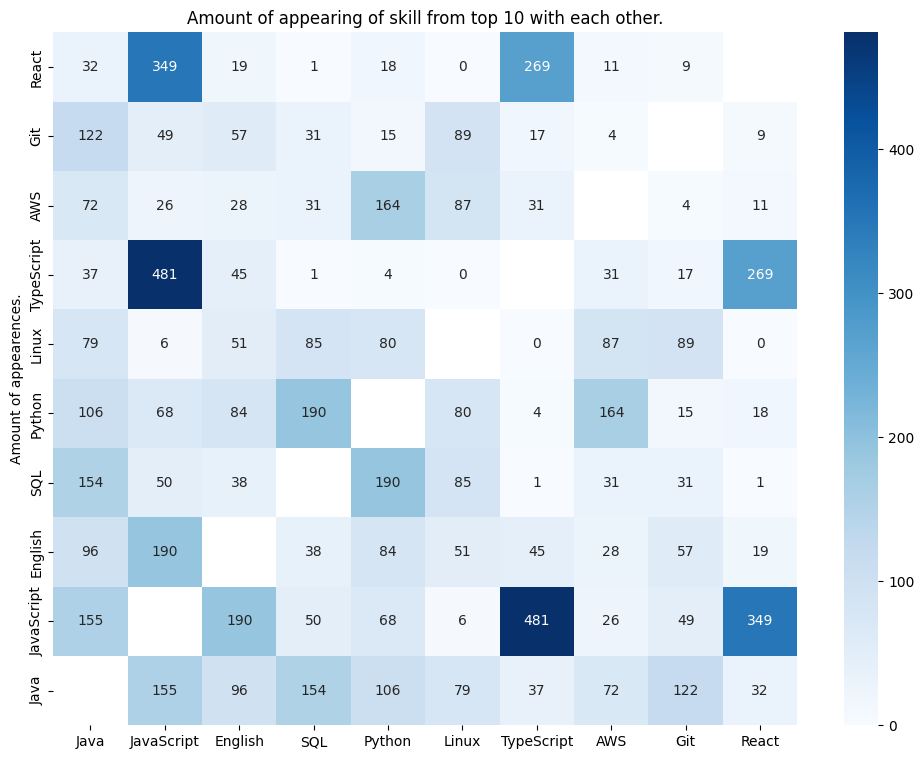

In [14]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

plt.figure(figsize=(12, 9))
plt.title(f"Amount of appearing of skill from top 10 with each other.")

plot = sns.heatmap(df_repetitions, annot=True, fmt='g', cmap="Blues")

plt.ylabel("Amount of appearences.")
